In [161]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import re

# Load the spaCy model
nlp = spacy.load("en_core_web_lg")

In [162]:
def extract_names(text):
    doc = nlp(text)
    names = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    return names

def find_relationships(text, window=15):
    doc = nlp(text)
    names = [(ent.text, ent.start) for ent in doc.ents if ent.label_ == 'PERSON' and (ent.root.dep_ in ['nsubj', 'dobj', 'pobj', 'attr'])]
    connections = []
    
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            if abs(names[i][1] - names[j][1]) <= window:
                connections.append((names[i][0], names[j][0]))
                
    return connections

def create_graph(connections):
    G = nx.Graph()
    for conn in connections:
        G.add_edge(conn[0], conn[1])
    return G

def plot_graph(G):
    plt.figure(figsize=(12, 12))
    nx.draw_networkx(G, with_labels=True, node_color='skyblue', edge_color='#FF5733', font_size=10, font_weight='bold')
    plt.show()

In [163]:
file_path = 'journal_txt.txt'

def read_journal(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

def parse_journal_entries(content):
    entries = []
    # Pattern to identify the start of a journal entry (author and date)
    entry_pattern = re.compile(r'by (Willa Silverman|Ben Berkman|Ethan Silverman), \w+ \d{1,2}, \d{4}')

    entries_start = [match.start() for match in re.finditer(entry_pattern, content)]

    for i in range(len(entries_start)):
        start = entries_start[i]
        end = entries_start[i + 1] if i + 1 < len(entries_start) else len(content)

        # Extract the whole entry content
        entry_content = content[start:end].strip()

        # Extracting and formatting the title, author, and date
        title_start = content.rfind('\n', 0, start)
        title_end = content.rfind('\n', 0, title_start)
        title = content[title_end:title_start].strip()

        author_date_line = content[start:content.find('\n', start)].strip()
        author, date = author_date_line.split(',', 1)
        author = author.replace('by ', '').strip()
        date = date.strip()

        # Removing the redundant author-date line from the entry content
        entry_text = entry_content.replace(author_date_line, "", 1).strip()

        # Splitting entry content and comments
        comments_start = re.search(r'\nComments\n', entry_text)
        if comments_start:
            comments = entry_text[comments_start.end():].strip()
            entry_text = entry_text[:comments_start.start()].strip()
        else:
            comments = ""

        entries.append({
            'title': title,
            'author': author,
            'date': date,
            'entry': entry_text,
            'comments': comments
        })

    return entries

In [164]:
journal_content = read_journal(file_path)
parsed_entries = parse_journal_entries(journal_content)

In [173]:
entries = []

for i in parsed_entries:
    entry = i['entry'].replace('\n', ' ')
    entries.append(entry)

In [177]:
combined_text = ''.join(entries)

In [178]:
len(combined_text)

1628505

In [199]:
start = 0
end = 1628505
window = 1000000
# text = combined_text[start:start+window]
text = combined_text[end-window:end]

In [211]:
connections = find_relationships(text)

In [212]:
# connections

In [218]:
def update_connections(connections):
    updated_connections = []
    for name1, name2 in connections:
        
        # Rename if 'Willa' is part of the name
        if "willa" in name1.lower():
            name1 = "Willa"
        if "willa" in name2.lower():
            name2 = "Willa"

        if "ethan" in name1.lower():
            name1 = "Ethan"
        if "ethan" in name2.lower():
            name2 = "Ethan"

        if "ben" in name1.lower():
            name1 = "Ben"
        if "ben" in name2.lower():
            name2 = "Ben"
        
        if "patel" in name1.lower():
            name1 = "Dr. Patel"
        if "patel" in name2.lower():
            name2 = "Dr. Patel"
            
        if "beavis" in name1.lower():
            name1 = "Dr. Beavis"
        if "beavis" in name2.lower():
            name2 = "Dr. Beavis"
        
        # Add to list only if names are not the same
        if name1 != name2:
            updated_connections.append((name1, name2))
            
    return updated_connections

In [219]:
connections = update_connections(connections)

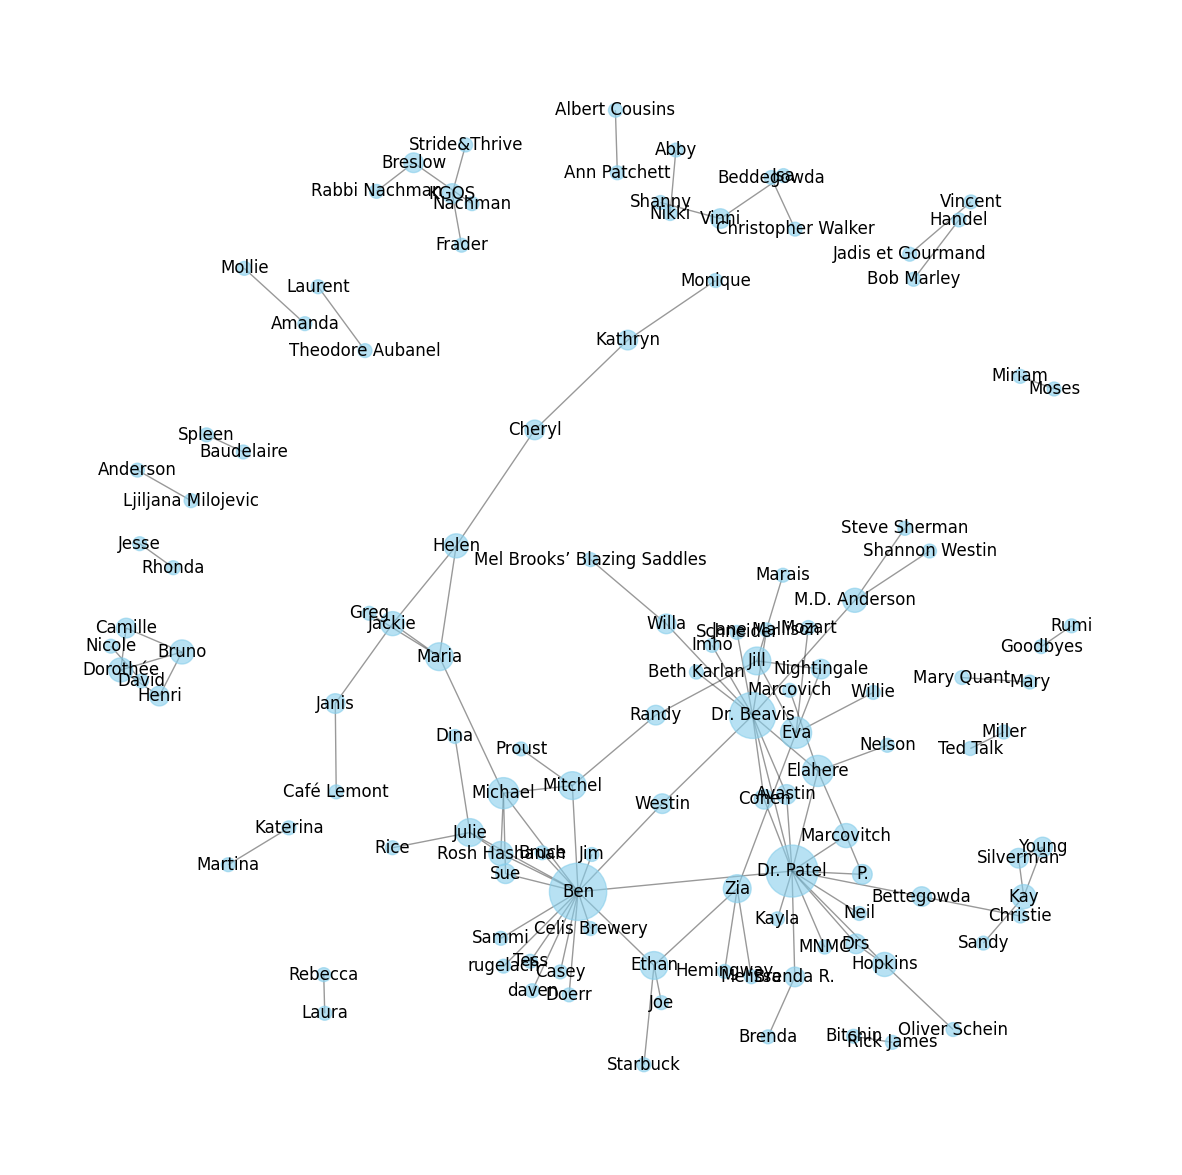

In [222]:
import networkx as nx
import matplotlib.pyplot as plt

G = create_graph(connections)

def plot_graph(G):
    plt.figure(figsize=(15, 15))  # Increase figure size for better visibility

    # Filter out nodes with a degree of 1
    filtered_G = G.copy()
    # low_degree_nodes = [node for node in filtered_G.nodes() if filtered_G.degree(node) == 1]
    # filtered_G.remove_nodes_from(low_degree_nodes)

    # Generate position layout for nodes using the spring layout
    pos = nx.spring_layout(filtered_G, k=0.2, iterations=50)  # Adjust k and iterations as needed

    # Get the degree of each node in the filtered graph and scale node sizes accordingly
    degrees = [filtered_G.degree(n) * 100 for n in filtered_G.nodes()]  # Scale factor can be adjusted

    # Draw nodes with sizes based on degree
    nx.draw_networkx_nodes(filtered_G, pos, node_size=degrees, node_color='skyblue', alpha=0.6)

    # Draw edges and labels
    nx.draw_networkx_edges(filtered_G, pos, alpha=0.4)
    nx.draw_networkx_labels(filtered_G, pos, font_size=12, font_family='sans-serif')

    # Set graph title and hide axes
    # plt.title('Graph of Name Relationships')
    plt.axis('off')  # Hide the axes

    plt.show()

# Create your graph G and call the plot_graph function
plot_graph(G)